# Basic Classification using Team Stats

In this notebook, we will begin the exploration of the following question:
<center> How do team stats predict whether a team wins? <br>
    
More specifically, 
<center> Can a box score (ignoring Difference in Points scored) show which team won? Can the difference in stats, like rebounds and assists, essentially determine whether a team won?<br>

In a previous notebook, we gathered team stats for every NBA game since the 2008-2009 season. 

Here, we will consider the team stats for the Warriors and their opponents for the 2017-2018 season, and organize them in two DataFrames. After viewing the data using a PairGrid and summary statistics, we will run Principal Component and Support Vector Machine to obtain interesting classification results.

Let's get started!

In [1]:
% matplotlib inline


#necessary libraries
import numpy as np

import pandas as pd
pd.set_option('display.max_columns',None)
from pandas.util.testing import assert_frame_equal

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

from datetime import datetime
import time
from nose.tools import assert_equal

import sqlite3

## Collecting 2017-2018 Warriors team data

We will first do analysis on the team stats for the Warriors during the 2017-2018 season. We start by organizing all of the team stats data for the season.

In [2]:
#import team data for all games since 2009-2010 season 
all_team_stats = pd.read_csv('all_team_stats_2009_to_2018.csv').loc[:,'team':]

print(all_team_stats.columns.tolist())

all_team_stats.head()

['team', 'first_qtr_points', 'second_qtr_points', 'third_qtr_points', 'fourth_qtr_points', 'total_points', 'fg_made', 'fg_attempted', 'fg_percentage', 'threept_made', 'threept_attempted', 'threept_percentage', 'ft_made', 'ft_attempted', 'ft_percentage', 'total_rebounds', 'offensive_rebounds', 'defensive_rebounds', 'assists', 'steals', 'blocks', 'total_turnovers', 'points_off_turnovers', 'fast_break_points', 'points_in_paint', 'personal_fouls', 'technical_fouls', 'flagrant_fouls', 'number_of_ot_periods', 'ot_points', 'won', 'away_or_home', 'matchup_id']


,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,DAL,21,23,25,27,96,39,78,50.0,9,23,39.1,9,10,90.0,52,8,39,21,2,4,28,8,8,0,16,1,0,0,[],1,Away,281217028
1,TOR,33,16,14,23,86,36,84,42.9,4,11,36.4,10,13,76.9,39,7,30,17,7,4,12,17,8,0,14,0,0,0,[],0,Home,281217028
2,GS,26,19,17,26,88,36,90,40.0,5,21,23.8,11,13,84.6,48,10,31,13,6,6,32,6,10,38,21,1,0,0,[],0,Away,290304004
3,CHI,20,31,24,35,110,39,86,45.3,5,8,62.5,27,32,84.4,60,17,37,19,7,7,26,24,18,46,16,0,0,0,[],1,Home,290304004
4,MIL,20,19,19,15,73,28,75,37.3,4,18,22.2,13,14,92.9,46,8,33,19,7,3,36,13,10,24,23,0,0,0,[],0,Away,290304005


In [3]:
#stats are type numpy int64
assert_equal(all_team_stats.loc[1,'second_qtr_points'], 16)
assert_equal(type(all_team_stats.loc[1,'second_qtr_points']), np.int64)

In [4]:
#find games by Matchup ID for Warriors season
all_game_info = pd.read_csv('all_games_04_on.csv').loc[:,'team':]

#print(all_game_info.columns)
#print(type(all_game_info.loc[0,'season_end_year']))

#restrict to 2017-2018 season
season_year_bool = all_game_info['season_end_year'] == 2018

#restrict to Warriors games
team_bool = all_game_info['team'] == 'gs'

all_game_info_gs_18 = all_game_info[season_year_bool & team_bool]

all_game_info_gs_18.head()

,team,season_start_year,season_end_year,season_type,game_month,game_day,game_year,game_date,matchup_id
31746,gs,2017,2018,regular,10,17,2017,10/17/2017,400974438
31747,gs,2017,2018,regular,10,20,2017,10/20/2017,400974444
31748,gs,2017,2018,regular,10,21,2017,10/21/2017,400974784
31749,gs,2017,2018,regular,10,23,2017,10/23/2017,400974796
31750,gs,2017,2018,regular,10,25,2017,10/25/2017,400974814


In [5]:
#Warriors played 82 regular season games and 21 postseason games
regular_season_bool = all_game_info_gs_18['season_type'] == 'regular'
postseason_bool = all_game_info_gs_18['season_type'] == 'postseason'

assert_equal(all_game_info_gs_18[regular_season_bool].shape[0], 82)
assert_equal(all_game_info_gs_18[postseason_bool].shape[0], 21)

We will now use SQLite to match up the game information with the team stats for each game.

In [6]:
#use R 
#do sidebyside Python and R

home_dir = !echo $HOME

#Define data directory
database_dir = home_dir[0] + '/database'

print(f'Database will persist at {database_dir}\n')

Database will persist at /Users/derekjung/database



In [7]:
%%bash -s "$database_dir"

#passed Python variable, later accessed with $1

#check if directory exists
if [ -d "$1" ] ; then

    echo "Directory already exists."

else
    #otherwise grapb file from Internet and store locally in data directory
    
    mkdir $1
    echo "creating database directory"

fi

Directory already exists.


In [8]:
con = sqlite3.connect("stats_618.db")

cur = con.cursor()

In [9]:
all_game_info_gs_18.to_sql(name='game_info_gs_18_tb', con=con, if_exists='replace',\
                          index=False, chunksize=1000)

#view some of game info table
sql_game_access = "\
SELECT * \
FROM game_info_gs_18_tb \
LIMIT 3 \
"

cur.execute(sql_game_access)

for row in cur:
    print(row)

('gs', 2017, 2018, 'regular', 10, 17, 2017, '10/17/2017', 400974438)
('gs', 2017, 2018, 'regular', 10, 20, 2017, '10/20/2017', 400974444)
('gs', 2017, 2018, 'regular', 10, 21, 2017, '10/21/2017', 400974784)


In [10]:
#count number of games in table

sql_count = "\
SELECT COUNT(*)\
FROM game_info_gs_18_tb \
"

cur.execute(sql_count)

for row in cur:
    print(row[0]) #number of games in table

103


In [11]:
all_team_stats.to_sql(name='all_team_stats_tb', con=con, if_exists='replace',
                     index=False, chunksize=1000)

sql_stats_access = "\
SELECT * \
FROM all_team_stats_tb \
LIMIT 3 \
"

cur.execute(sql_stats_access)

for row in cur:
    print(row)

('DAL', 21, 23, 25, 27, 96, 39, 78, 50.0, 9, 23, 39.1, 9, 10, 90.0, 52, 8, 39, 21, 2, 4, 28, 8, 8, 0, 16, 1, 0, 0, '[]', 1, 'Away', 281217028)
('TOR', 33, 16, 14, 23, 86, 36, 84, 42.9, 4, 11, 36.4, 10, 13, 76.9, 39, 7, 30, 17, 7, 4, 12, 17, 8, 0, 14, 0, 0, 0, '[]', 0, 'Home', 281217028)
('GS', 26, 19, 17, 26, 88, 36, 90, 40.0, 5, 21, 23.8, 11, 13, 84.6, 48, 10, 31, 13, 6, 6, 32, 6, 10, 38, 21, 1, 0, 0, '[]', 0, 'Away', 290304004)


In [12]:
sql_game_stats_join = "\
SELECT DISTINCT game_tb.season_end_year, game_tb.season_type,\
game_tb.game_date, game_tb.matchup_id AS game_matchup_id, \
team_tb.*\
FROM game_info_gs_18_tb AS game_tb \
JOIN all_team_stats_tb AS team_tb \
ON game_tb.matchup_id = team_tb.matchup_id \
"

team_stats_gs_18 = pd.read_sql(sql_game_stats_join, con)

team_stats_gs_18.head(10)

,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,2018,regular,10/17/2017,400974438,GS,35,36,30,20,121,43,80,53.8,16,30,53.3,19,21,90.5,42,6,35,34,5,9,17,21,36,32,25,0,0,0,[],0,Home,400974438
1,2018,regular,10/17/2017,400974438,HOU,34,28,26,34,122,47,97,48.5,15,41,36.6,13,19,68.4,53,10,33,28,9,5,13,11,15,54,16,1,1,0,[],1,Away,400974438
2,2018,regular,10/20/2017,400974444,GS,26,35,37,30,128,47,92,51.1,18,41,43.9,16,20,80.0,53,10,39,29,6,8,18,28,23,30,23,1,0,0,[],1,Away,400974444
3,2018,regular,10/20/2017,400974444,NO,39,25,26,30,120,45,98,45.9,16,36,44.4,14,22,63.6,57,16,35,26,8,4,19,18,14,32,19,1,0,0,[],0,Home,400974444
4,2018,regular,10/21/2017,400974784,GS,26,25,20,30,101,33,84,39.3,12,38,31.6,23,27,85.2,55,12,34,20,10,7,17,24,32,36,28,3,0,0,[],0,Away,400974784
5,2018,regular,10/21/2017,400974784,MEM,31,25,32,23,111,36,77,46.8,10,27,37.0,29,37,78.4,49,6,34,20,8,4,14,16,21,48,25,0,0,0,[],1,Home,400974784
6,2018,regular,10/23/2017,400974796,DAL,24,38,22,19,103,38,96,39.6,9,29,31.0,18,30,60.0,55,14,28,21,11,0,12,15,8,44,20,1,0,0,[],0,Home,400974796
7,2018,regular,10/23/2017,400974796,GS,40,25,34,34,133,48,86,55.8,15,39,38.5,22,26,84.6,57,10,40,33,6,8,16,18,34,44,23,1,0,0,[],1,Away,400974796
8,2018,regular,10/25/2017,400974814,GS,29,32,30,26,117,43,77,55.8,12,26,46.2,19,22,86.4,41,6,31,32,10,7,17,17,33,48,15,0,0,0,[],1,Home,400974814
9,2018,regular,10/25/2017,400974814,TOR,26,27,33,26,112,43,94,45.7,8,34,23.5,18,19,94.7,48,17,25,30,10,6,18,17,15,54,16,0,0,0,[],0,Away,400974814


In [13]:
#DataFrame has number of rows equal to 2 * number of games
assert_equal(team_stats_gs_18.loc[:,'season_end_year'].shape[0], 2*103)

#check stats are of right type
assert_equal(type(team_stats_gs_18.loc[0,'ft_percentage']), np.float64)
assert_equal(type(team_stats_gs_18.loc[0,'first_qtr_points']), np.int64)

In [14]:
#split up DataFrame in Warriors stats and opponents stats
team_stats_gs_18_gs = team_stats_gs_18[team_stats_gs_18['team']=='GS']
team_stats_gs_18_opponents = team_stats_gs_18[team_stats_gs_18['team']!='GS']

In [15]:
#first few rows of Warriors stats
team_stats_gs_18_gs.head()

,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,2018,regular,10/17/2017,400974438,GS,35,36,30,20,121,43,80,53.8,16,30,53.3,19,21,90.5,42,6,35,34,5,9,17,21,36,32,25,0,0,0,[],0,Home,400974438
2,2018,regular,10/20/2017,400974444,GS,26,35,37,30,128,47,92,51.1,18,41,43.9,16,20,80.0,53,10,39,29,6,8,18,28,23,30,23,1,0,0,[],1,Away,400974444
4,2018,regular,10/21/2017,400974784,GS,26,25,20,30,101,33,84,39.3,12,38,31.6,23,27,85.2,55,12,34,20,10,7,17,24,32,36,28,3,0,0,[],0,Away,400974784
7,2018,regular,10/23/2017,400974796,GS,40,25,34,34,133,48,86,55.8,15,39,38.5,22,26,84.6,57,10,40,33,6,8,16,18,34,44,23,1,0,0,[],1,Away,400974796
8,2018,regular,10/25/2017,400974814,GS,29,32,30,26,117,43,77,55.8,12,26,46.2,19,22,86.4,41,6,31,32,10,7,17,17,33,48,15,0,0,0,[],1,Home,400974814


In [16]:
#first few rows of opponents stats
team_stats_gs_18_opponents.head()

,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
1,2018,regular,10/17/2017,400974438,HOU,34,28,26,34,122,47,97,48.5,15,41,36.6,13,19,68.4,53,10,33,28,9,5,13,11,15,54,16,1,1,0,[],1,Away,400974438
3,2018,regular,10/20/2017,400974444,NO,39,25,26,30,120,45,98,45.9,16,36,44.4,14,22,63.6,57,16,35,26,8,4,19,18,14,32,19,1,0,0,[],0,Home,400974444
5,2018,regular,10/21/2017,400974784,MEM,31,25,32,23,111,36,77,46.8,10,27,37.0,29,37,78.4,49,6,34,20,8,4,14,16,21,48,25,0,0,0,[],1,Home,400974784
6,2018,regular,10/23/2017,400974796,DAL,24,38,22,19,103,38,96,39.6,9,29,31.0,18,30,60.0,55,14,28,21,11,0,12,15,8,44,20,1,0,0,[],0,Home,400974796
9,2018,regular,10/25/2017,400974814,TOR,26,27,33,26,112,43,94,45.7,8,34,23.5,18,19,94.7,48,17,25,30,10,6,18,17,15,54,16,0,0,0,[],0,Away,400974814


In [17]:
#reindex DataFrames to row number
team_stats_gs_18_gs = team_stats_gs_18_gs.reset_index(drop=True)
team_stats_gs_18_opponents = team_stats_gs_18_opponents.reset_index(drop=True)
#del team_stats_gs_18_opponents['index']

In [18]:
#check that row numbers have been reindexed
team_stats_gs_18_gs.head()

,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,2018,regular,10/17/2017,400974438,GS,35,36,30,20,121,43,80,53.8,16,30,53.3,19,21,90.5,42,6,35,34,5,9,17,21,36,32,25,0,0,0,[],0,Home,400974438
1,2018,regular,10/20/2017,400974444,GS,26,35,37,30,128,47,92,51.1,18,41,43.9,16,20,80.0,53,10,39,29,6,8,18,28,23,30,23,1,0,0,[],1,Away,400974444
2,2018,regular,10/21/2017,400974784,GS,26,25,20,30,101,33,84,39.3,12,38,31.6,23,27,85.2,55,12,34,20,10,7,17,24,32,36,28,3,0,0,[],0,Away,400974784
3,2018,regular,10/23/2017,400974796,GS,40,25,34,34,133,48,86,55.8,15,39,38.5,22,26,84.6,57,10,40,33,6,8,16,18,34,44,23,1,0,0,[],1,Away,400974796
4,2018,regular,10/25/2017,400974814,GS,29,32,30,26,117,43,77,55.8,12,26,46.2,19,22,86.4,41,6,31,32,10,7,17,17,33,48,15,0,0,0,[],1,Home,400974814


In [19]:
team_stats_gs_18_opponents.head()

,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home,matchup_id
0,2018,regular,10/17/2017,400974438,HOU,34,28,26,34,122,47,97,48.5,15,41,36.6,13,19,68.4,53,10,33,28,9,5,13,11,15,54,16,1,1,0,[],1,Away,400974438
1,2018,regular,10/20/2017,400974444,NO,39,25,26,30,120,45,98,45.9,16,36,44.4,14,22,63.6,57,16,35,26,8,4,19,18,14,32,19,1,0,0,[],0,Home,400974444
2,2018,regular,10/21/2017,400974784,MEM,31,25,32,23,111,36,77,46.8,10,27,37.0,29,37,78.4,49,6,34,20,8,4,14,16,21,48,25,0,0,0,[],1,Home,400974784
3,2018,regular,10/23/2017,400974796,DAL,24,38,22,19,103,38,96,39.6,9,29,31.0,18,30,60.0,55,14,28,21,11,0,12,15,8,44,20,1,0,0,[],0,Home,400974796
4,2018,regular,10/25/2017,400974814,TOR,26,27,33,26,112,43,94,45.7,8,34,23.5,18,19,94.7,48,17,25,30,10,6,18,17,15,54,16,0,0,0,[],0,Away,400974814


In [20]:
#both DataFrames have one row for each game of the season
assert_equal(team_stats_gs_18_gs.shape[0], 103)
assert_equal(team_stats_gs_18_opponents.shape[0], 103)

## PCA on Warriors games

We now have two DataFrames for the Warriors 2017-2018 season: `team_stats_gs_18_gs` and `team_stats_gs_18_opponents`. Each one has exactly 103 rows, one for each game of the Warriors season. `team_stats_gs_18_gs`, `team_stats_gs_18_opponents` contain the Warrior's, opponent's team stats for every game. 

We will run Principal Component Analysis (PCA) on these team stats. More specifically, we will consider the differences of each stat for each game to turn our two DataFrames into one. We will then consider how these differences affect winning. 

In [21]:
#create DataFrame of differences
team_stats_gs_18_diff = team_stats_gs_18_gs.copy(deep=True)

#take differences of all stats from 'first_qtr_points' to 'flagrant_fouls'
column_names = team_stats_gs_18_diff.columns.tolist()

first_qtr_pts_index = column_names.index('first_qtr_points')
flagrant_fouls_index = column_names.index('flagrant_fouls')

#column names to take differences of
column_names_diff = column_names[first_qtr_pts_index:flagrant_fouls_index+1]
print(column_names_diff)

['first_qtr_points', 'second_qtr_points', 'third_qtr_points', 'fourth_qtr_points', 'total_points', 'fg_made', 'fg_attempted', 'fg_percentage', 'threept_made', 'threept_attempted', 'threept_percentage', 'ft_made', 'ft_attempted', 'ft_percentage', 'total_rebounds', 'offensive_rebounds', 'defensive_rebounds', 'assists', 'steals', 'blocks', 'total_turnovers', 'points_off_turnovers', 'fast_break_points', 'points_in_paint', 'personal_fouls', 'technical_fouls', 'flagrant_fouls']


In [22]:
for col in column_names_diff:
    team_stats_gs_18_diff.loc[:,col] = team_stats_gs_18_gs.loc[:,col] - team_stats_gs_18_opponents.loc[:,col]
    
#drop redundant last Matchup ID column
del team_stats_gs_18_diff['matchup_id']
    
team_stats_gs_18_diff.describe()

,season_end_year,game_matchup_id,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,won
count,103.0,1.030000e+02,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,2018.0,4.009869e+08,0.077670,1.310680,5.087379,0.165049,6.796117,2.932039,-4.174757,5.732039,0.912621,-0.446602,3.241748,0.019417,-1.485437,5.494175,-0.980583,-2.203883,3.407767,5.689320,-0.514563,3.475728,0.728155,0.456311,5.029126,-3.553398,0.941748,0.320388,-0.029126,0.029126,0.718447
std,0.0,2.297572e+04,7.777153,8.489935,9.799066,8.350293,15.466827,6.924328,7.490422,7.784741,4.840813,8.633869,12.842924,6.916846,7.909865,13.614704,10.022505,5.796143,6.225244,6.778034,3.975079,3.764761,4.518359,8.447968,10.103830,12.103903,4.500164,1.156513,0.260328,0.168983,0.451956
min,2018.0,4.009744e+08,-19.000000,-21.000000,-18.000000,-17.000000,-40.000000,-18.000000,-22.000000,-18.400000,-9.000000,-24.000000,-30.000000,-21.000000,-21.000000,-28.600000,-23.000000,-16.000000,-12.000000,-14.000000,-13.000000,-6.000000,-12.000000,-20.000000,-23.000000,-28.000000,-10.000000,-3.000000,-1.000000,0.000000,0.000000
25%,2018.0,4.009751e+08,-5.000000,-4.500000,-3.000000,-6.000000,-4.000000,-1.500000,-9.500000,0.600000,-3.000000,-5.500000,-5.100000,-5.500000,-7.500000,-3.000000,-9.000000,-6.000000,-0.500000,1.000000,-3.000000,1.000000,-2.000000,-5.000000,-1.000000,-12.000000,-2.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.0,4.009755e+08,-1.000000,1.000000,6.000000,0.000000,8.000000,3.000000,-5.000000,7.100000,1.000000,-1.000000,4.300000,0.000000,-2.000000,4.300000,0.000000,-3.000000,4.000000,5.000000,0.000000,3.000000,1.000000,1.000000,5.000000,-2.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,2018.0,4.009759e+08,6.000000,6.500000,11.500000,6.000000,15.000000,7.000000,0.000000,11.400000,4.000000,4.500000,9.400000,5.000000,3.500000,15.000000,6.000000,1.000000,8.000000,10.500000,2.000000,6.000000,3.500000,5.500000,11.500000,4.000000,4.000000,1.000000,0.000000,0.000000,1.000000
max,2018.0,4.010346e+08,16.000000,24.000000,32.000000,22.000000,49.000000,19.000000,15.000000,23.700000,15.000000,28.000000,34.100000,15.000000,21.000000,45.900000,21.000000,17.000000,17.000000,23.000000,9.000000,13.000000,12.000000,26.000000,33.000000,26.000000,15.000000,5.000000,1.000000,1.000000,1.000000


In [23]:
team_stats_gs_18_diff.head()

,season_end_year,season_type,game_date,game_matchup_id,team,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,technical_fouls,flagrant_fouls,number_of_ot_periods,ot_points,won,away_or_home
0,2018,regular,10/17/2017,400974438,GS,1,8,4,-14,-1,-4,-17,5.3,1,-11,16.7,6,2,22.1,-11,-4,2,6,-4,4,4,10,21,-22,9,-1,-1,0,[],0,Home
1,2018,regular,10/20/2017,400974444,GS,-13,10,11,0,8,2,-6,5.2,2,5,-0.5,2,-2,16.4,-4,-6,4,3,-2,4,-1,10,9,-2,4,0,0,0,[],1,Away
2,2018,regular,10/21/2017,400974784,GS,-5,0,-12,7,-10,-3,7,-7.5,2,11,-5.4,-6,-10,6.8,6,6,0,0,2,3,3,8,11,-12,3,3,0,0,[],0,Away
3,2018,regular,10/23/2017,400974796,GS,16,-13,12,15,30,10,-10,16.2,6,10,7.5,4,-4,24.6,2,-4,12,12,-5,8,4,3,26,0,3,0,0,0,[],1,Away
4,2018,regular,10/25/2017,400974814,GS,3,5,-3,0,5,0,-17,10.1,4,-8,22.7,1,3,-8.3,-7,-11,6,2,0,1,-1,0,18,-6,-1,0,0,0,[],1,Home


We make one important observation here: The team that scores the most points wins the game! This seems obvious, but the crucial point is that the principal component for classifying winning is difference in points scored. 

We push the point further by showing that difference in points is 100% accurate in predicting winning. Note the column `won` in our DataFrame `team_stats_gs_18_diff` equals $1$ when the Warriors win and $0$ when the Warriors lose.

In [24]:
def num_to_binary(num):
    '''
    Returns 1 if a number is positive, 0 if a number is negative,
    and 0.5 if a number equals 0.
    
    Input:
    num (int or float)
    
    Output:
    0, 0.5, or 1
    '''
    
    if num > 0:
        return 1
    
    elif num < 0:
        return 0
    
    elif num == 0:
        return 0.5

In [25]:
from sklearn.metrics import accuracy_score, classification_report

predicted_by_score = team_stats_gs_18_diff.loc[:,'total_points'].apply(num_to_binary)

score = accuracy_score(predicted_by_score, team_stats_gs_18_diff.loc[:,'won'])

print('Accuracy by difference in points scored: {0}%'.format(str(100*score))) 

print(classification_report(predicted_by_score, team_stats_gs_18_diff.loc[:,'won']))

Accuracy by difference in points scored: 100.0%
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        29
          1       1.00      1.00      1.00        74

avg / total       1.00      1.00      1.00       103



We see that predicting based on points scored alone is 100% accurate as expected. 

We now make the following observation:

$
    \textrm(Points \  scored) = 2*\textrm(FG \ made) + \textrm(3PT \ FG \ made) + \textrm(FT \ made).
$

This might seem curious because you score 3 points for every 3-pointer made (aptly named!). But one must note that the 'FG made' stat counts both 2 pointers and 3 pointers made. Thus, in effect, the extra summand of `3PT FG made` adds an extra point for each 3 PT shot made.

Since everything is linear, note

$
    \textrm(Difference \ in \ Points \  scored) = 2*\textrm(Difference \ in \ FG \ made) + \textrm(Difference \ in \ 3PT \ FG \ made) + \textrm(Difference \ in \ FT \ made).
$

Recall that Difference in Points scored completely determines whether a team wins. This implies that the three stats `Difference in FG made`, `Diference in 3PT FG made`, and `Difference in FT made` completely determine winning.

In [26]:
'''
from sklearn.decomposition import PCA

features = team_stats_gs_18_diff[['fg_made', 'three_pt_made', 'ft_made']].values

labels = team_stats_gs_18_diff.loc[:,'won']

#principal component analysis
pca = PCA()

pca.fit(features)

vars = pca.explained_variance_ratio_
c_names = ['fg_made', 'three_pt_made', 'ft_made']

print('Variance: Projected dimension')
'''

"\nfrom sklearn.decomposition import PCA\n\nfeatures = team_stats_gs_18_diff[['fg_made', 'three_pt_made', 'ft_made']].values\n\nlabels = team_stats_gs_18_diff.loc[:,'won']\n\n#principal component analysis\npca = PCA()\n\npca.fit(features)\n\nvars = pca.explained_variance_ratio_\nc_names = ['fg_made', 'three_pt_made', 'ft_made']\n\nprint('Variance: Projected dimension')\n"

We will first construct a pairplot and perform a PCA to better understand our data. For the sake of reducing the numbers, we will not consider technical fouls, flagrant fouls, and overtime performance.

In [27]:
print(team_stats_gs_18_diff.columns.tolist())

['season_end_year', 'season_type', 'game_date', 'game_matchup_id', 'team', 'first_qtr_points', 'second_qtr_points', 'third_qtr_points', 'fourth_qtr_points', 'total_points', 'fg_made', 'fg_attempted', 'fg_percentage', 'threept_made', 'threept_attempted', 'threept_percentage', 'ft_made', 'ft_attempted', 'ft_percentage', 'total_rebounds', 'offensive_rebounds', 'defensive_rebounds', 'assists', 'steals', 'blocks', 'total_turnovers', 'points_off_turnovers', 'fast_break_points', 'points_in_paint', 'personal_fouls', 'technical_fouls', 'flagrant_fouls', 'number_of_ot_periods', 'ot_points', 'won', 'away_or_home']


In [28]:
column_names = team_stats_gs_18_diff.columns.tolist()

first_qtr_pts_index = column_names.index('first_qtr_points')
personal_fouls_index = column_names.index('personal_fouls')

less_team_stats_names = column_names[first_qtr_pts_index:personal_fouls_index+1]

less_team_stats_gs_18 = team_stats_gs_18_diff[less_team_stats_names + ['won']]

less_team_stats_gs_18.head()

,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,won
0,1,8,4,-14,-1,-4,-17,5.3,1,-11,16.7,6,2,22.1,-11,-4,2,6,-4,4,4,10,21,-22,9,0
1,-13,10,11,0,8,2,-6,5.2,2,5,-0.5,2,-2,16.4,-4,-6,4,3,-2,4,-1,10,9,-2,4,1
2,-5,0,-12,7,-10,-3,7,-7.5,2,11,-5.4,-6,-10,6.8,6,6,0,0,2,3,3,8,11,-12,3,0
3,16,-13,12,15,30,10,-10,16.2,6,10,7.5,4,-4,24.6,2,-4,12,12,-5,8,4,3,26,0,3,1
4,3,5,-3,0,5,0,-17,10.1,4,-8,22.7,1,3,-8.3,-7,-11,6,2,0,1,-1,0,18,-6,-1,1


In [29]:
#show summary statistics for differences
less_team_stats_describe = less_team_stats_gs_18.describe()

less_team_stats_describe

,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls,won
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.077670,1.310680,5.087379,0.165049,6.796117,2.932039,-4.174757,5.732039,0.912621,-0.446602,3.241748,0.019417,-1.485437,5.494175,-0.980583,-2.203883,3.407767,5.689320,-0.514563,3.475728,0.728155,0.456311,5.029126,-3.553398,0.941748,0.718447
std,7.777153,8.489935,9.799066,8.350293,15.466827,6.924328,7.490422,7.784741,4.840813,8.633869,12.842924,6.916846,7.909865,13.614704,10.022505,5.796143,6.225244,6.778034,3.975079,3.764761,4.518359,8.447968,10.103830,12.103903,4.500164,0.451956
min,-19.000000,-21.000000,-18.000000,-17.000000,-40.000000,-18.000000,-22.000000,-18.400000,-9.000000,-24.000000,-30.000000,-21.000000,-21.000000,-28.600000,-23.000000,-16.000000,-12.000000,-14.000000,-13.000000,-6.000000,-12.000000,-20.000000,-23.000000,-28.000000,-10.000000,0.000000
25%,-5.000000,-4.500000,-3.000000,-6.000000,-4.000000,-1.500000,-9.500000,0.600000,-3.000000,-5.500000,-5.100000,-5.500000,-7.500000,-3.000000,-9.000000,-6.000000,-0.500000,1.000000,-3.000000,1.000000,-2.000000,-5.000000,-1.000000,-12.000000,-2.000000,0.000000
50%,-1.000000,1.000000,6.000000,0.000000,8.000000,3.000000,-5.000000,7.100000,1.000000,-1.000000,4.300000,0.000000,-2.000000,4.300000,0.000000,-3.000000,4.000000,5.000000,0.000000,3.000000,1.000000,1.000000,5.000000,-2.000000,1.000000,1.000000
75%,6.000000,6.500000,11.500000,6.000000,15.000000,7.000000,0.000000,11.400000,4.000000,4.500000,9.400000,5.000000,3.500000,15.000000,6.000000,1.000000,8.000000,10.500000,2.000000,6.000000,3.500000,5.500000,11.500000,4.000000,4.000000,1.000000
max,16.000000,24.000000,32.000000,22.000000,49.000000,19.000000,15.000000,23.700000,15.000000,28.000000,34.100000,15.000000,21.000000,45.900000,21.000000,17.000000,17.000000,23.000000,9.000000,13.000000,12.000000,26.000000,33.000000,26.000000,15.000000,1.000000


In [30]:
min_stats = less_team_stats_describe.loc['min',:].apply(lambda num: int(num))
max_stats = less_team_stats_describe.loc['max',:].apply(lambda num: int(num))

#min, max of each stat (limits for PairPlot)
team_stats_limits = [(min_stats[col], max_stats[col]) for col in less_team_stats_names]
print(team_stats_limits)

[(-19, 16), (-21, 24), (-18, 32), (-17, 22), (-40, 49), (-18, 19), (-22, 15), (-18, 23), (-9, 15), (-24, 28), (-30, 34), (-21, 15), (-21, 21), (-28, 45), (-23, 21), (-16, 17), (-12, 17), (-14, 23), (-13, 9), (-6, 13), (-12, 12), (-20, 26), (-23, 33), (-28, 26), (-10, 15)]


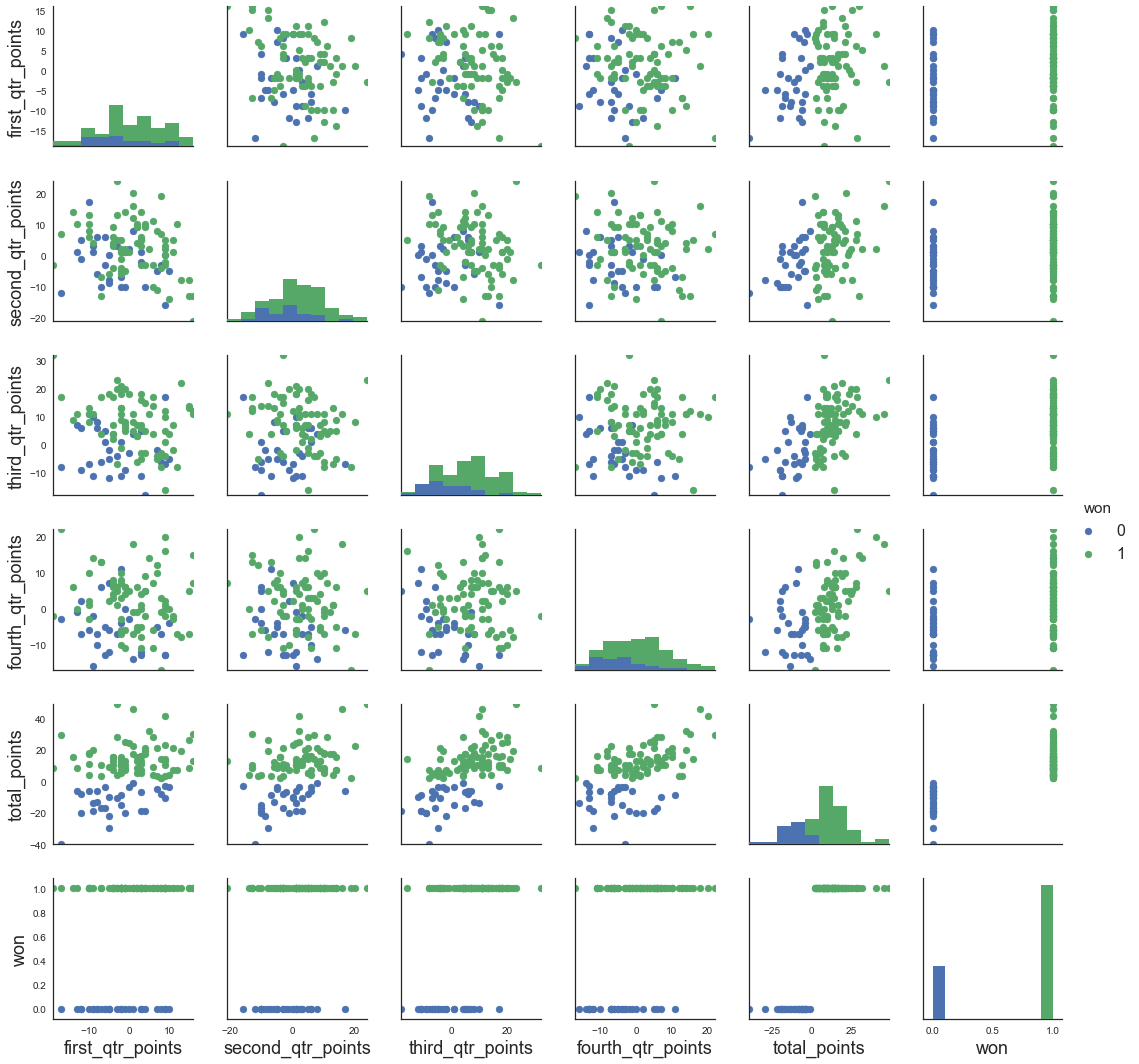

In [31]:
#compare points scored by quarter

#create PairPlot comparing points
g = sns.PairGrid(less_team_stats_gs_18[less_team_stats_names[:5]+['won']], hue='won')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

axes = g.axes

lim = team_stats_limits[:5]

for i in range(len(lim)):
    for j in range(len(lim)):
        axes[i, j].set_xlim(team_stats_limits[j])
        axes[i, j].set_ylim(team_stats_limits[i])

It appears that the Warriors tend to outscore teams primarily in the third and fourth quarters. In the third quarter, the Warriors tend to outscore opponents heavily in wins. That constrasts with the behavior during the first quarter, when differences in points scored tend to be more uniformly distributed over wins and ties.

We will now run a Principal Component Analysis on several stats of the Warriors. Rather than applying it to all stats, we will run it on (Difference in ) `total_points`, `total_rebounds`, `offensive_rebounds`, `defensive_rebounds`, and `assists`. Since the difference in `total_rebounds` is the sum of differences of `offensive_rebounds` and `defensive_rebounds`, we should see a PCA acknowledge this relationship. We should also see a relationship between `total_points` and `assists`, since heavily-passing teams tend to be successful. It will be interesting to see if there is a relationsihp between rebound statistics and points scored.

In [32]:
from sklearn.decomposition import PCA

features = less_team_stats_gs_18[['total_points', 'total_rebounds', \
                                  'offensive_rebounds', 'defensive_rebounds', 'assists']].values

pca = PCA()
pca.fit(features)

vars = pca.explained_variance_ratio_
s_names = ['total_points', 'total_rebounds', 'offensive_rebounds', 'defensive_rebounds', 'assists']

print('Variance: Projected dimension')
print('-----------------------------')

for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:       '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) \
                        for val, name in zip(row, s_names))
    
    print(output)


Variance: Projected dimension
-----------------------------
66.9%:       -0.85 * total_points + -0.35 * total_rebounds + -0.02 * offensive_rebounds + -0.28 * defensive_rebounds + -0.26 * assists
22.3%:       -0.33 * total_points +  0.78 * total_rebounds +  0.47 * offensive_rebounds +  0.17 * defensive_rebounds + -0.18 * assists
 5.6%:        0.38 * total_points + -0.07 * total_rebounds +  0.15 * offensive_rebounds + -0.27 * defensive_rebounds + -0.87 * assists
 4.3%:        0.12 * total_points + -0.12 * total_rebounds +  0.66 * offensive_rebounds + -0.63 * defensive_rebounds +  0.37 * assists
 0.9%:        0.00 * total_points +  0.51 * total_rebounds + -0.56 * offensive_rebounds + -0.65 * defensive_rebounds +  0.07 * assists


Wow, a single stat explains $67%$ of the variance and two stats explain $89%$ of the variance. This was very unexpected!

We will now see what happens when we run a PCA on all of the stats.

In [33]:
#remove team stat 'won'
less_team_stat_no_won = less_team_stats_gs_18.copy(deep=True)
del less_team_stat_no_won['won']

features = less_team_stat_no_won.values

#Principal Component Analysis on all main features
pca = PCA()
pca.fit(features)

vars = pca.explained_variance_ratio_
s_names = less_team_stat_no_won.columns.tolist()

print('Variance: Projected dimension')
print('-----------------------------')

for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:       '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) \
                        for val, name in zip(row, s_names))
    output += '\n'
    
    print(output)

Variance: Projected dimension
-----------------------------
31.5%:       -0.09 * first_qtr_points + -0.13 * second_qtr_points + -0.22 * third_qtr_points + -0.18 * fourth_qtr_points + -0.62 * total_points + -0.26 * fg_made + -0.03 * fg_attempted + -0.28 * fg_percentage + -0.11 * threept_made + -0.05 * threept_attempted + -0.35 * threept_percentage +  0.02 * ft_made +  0.02 * ft_attempted +  0.02 * ft_percentage + -0.17 * total_rebounds +  0.02 * offensive_rebounds + -0.18 * defensive_rebounds + -0.20 * assists + -0.04 * steals + -0.04 * blocks +  0.05 * total_turnovers +  0.14 * points_off_turnovers + -0.19 * fast_break_points + -0.25 * points_in_paint + -0.02 * personal_fouls

12.9%:        0.14 * first_qtr_points +  0.00 * second_qtr_points + -0.09 * third_qtr_points + -0.18 * fourth_qtr_points + -0.14 * total_points +  0.02 * fg_made + -0.13 * fg_attempted +  0.09 * fg_percentage +  0.11 * threept_made +  0.03 * threept_attempted +  0.35 * threept_percentage + -0.29 * ft_made + -0.18

In [34]:
#total number of stats
print(len(s_names))

25


There were over 25 different stats. Yet, we found $31.5%$ of the variance explained within one stat and $54%$ of the variance explained within 3 stats. This is surprising (to me, at least) since stats like `fg_attempted`, `personal_fouls`, and `assists` seem pretty disconnected. 

It shouldn't be surprising though that the coefficients of `first_qtr_points`, `second_qtr_points`, `third_qtr_points`, and `fourth_qtr_points` add up to that of `total_points` since the stats add up to each other. 

## SVM with PCA

We will now try to see if the single stat above (explaining around $31%$ of variance) does a good job of predicting whether a team by running SVM with PCA.

We first note what proportion of games the Warriors won.

In [35]:
output = 'Proportion of games Warriors won: '
output += str(less_team_stats_gs_18.loc[:,'won'].sum()/len(less_team_stats_gs_18.loc[:,'won']))

print(output)

Proportion of games Warriors won: 0.7184466019417476


This will be the baseline to beat for classification: a proportion of 0.718/percentage of 71.8%. This would representing by classifying all wins (or 'all spam' in the 'spam/ham' problem).

We now see how well the two principal components does in classifying with SVM.

In [36]:
from sklearn.model_selection import train_test_split

frac = 0.4

pca = PCA(n_components=2, random_state=23)
features_reduced = less_team_stat_no_won.values
labels = less_team_stats_gs_18.loc[:,'won']

f_train, f_test, l_train, l_test \
    = train_test_split(features_reduced, labels, test_size=frac, random_state=23)
    
from sklearn import svm

svc = svm.SVC(kernel='linear', C=1E6, random_state=23)

svc.fit(f_train,l_train)

result = svc.predict(f_test)

scr = 100.0 * svc.score(f_test, l_test)
print('SVM prediction accuracy: {0:1f}'.format(scr))

SVM prediction accuracy: 100.000000


This most likely occurred because `less_team_stat_no_won` contains information on the difference in team points, which determines a team wins.

Let's try to restrict to points that aren't directly related with points scored, omitting `fg_made`, `three_pt_made`, and `fg_made` and points issues.

In [37]:
less_names = less_team_stat_no_won.columns.tolist()

less_team_stat_no_won.head()

,first_qtr_points,second_qtr_points,third_qtr_points,fourth_qtr_points,total_points,fg_made,fg_attempted,fg_percentage,threept_made,threept_attempted,threept_percentage,ft_made,ft_attempted,ft_percentage,total_rebounds,offensive_rebounds,defensive_rebounds,assists,steals,blocks,total_turnovers,points_off_turnovers,fast_break_points,points_in_paint,personal_fouls
0,1,8,4,-14,-1,-4,-17,5.3,1,-11,16.7,6,2,22.1,-11,-4,2,6,-4,4,4,10,21,-22,9
1,-13,10,11,0,8,2,-6,5.2,2,5,-0.5,2,-2,16.4,-4,-6,4,3,-2,4,-1,10,9,-2,4
2,-5,0,-12,7,-10,-3,7,-7.5,2,11,-5.4,-6,-10,6.8,6,6,0,0,2,3,3,8,11,-12,3
3,16,-13,12,15,30,10,-10,16.2,6,10,7.5,4,-4,24.6,2,-4,12,12,-5,8,4,3,26,0,3
4,3,5,-3,0,5,0,-17,10.1,4,-8,22.7,1,3,-8.3,-7,-11,6,2,0,1,-1,0,18,-6,-1


In [38]:
rbd_index = less_names.index('total_rebounds')

#names of stats that don't involve shots or quarter/total points
no_points_names = less_names[rbd_index:]

no_points_names

['total_rebounds',
 'offensive_rebounds',
 'defensive_rebounds',
 'assists',
 'steals',
 'blocks',
 'total_turnovers',
 'points_off_turnovers',
 'fast_break_points',
 'points_in_paint',
 'personal_fouls']

In [39]:
frac = 0.4

pca = PCA(n_components=2, random_state=23)
features_reduced = less_team_stat_no_won[no_points_names].values
labels = less_team_stats_gs_18.loc[:,'won']

f_train, f_test, l_train, l_test \
    = train_test_split(features_reduced, labels, test_size=frac, random_state=23)
    
from sklearn import svm

svc = svm.SVC(kernel='linear', C=1E6, random_state=23)

svc.fit(f_train,l_train)

result = svc.predict(f_test)

scr = 100.0 * svc.score(f_test, l_test)
print('SVM prediction accuracy: {0:1f}'.format(scr))

SVM prediction accuracy: 97.619048


This is remarkable! What if we restrict to less stats? What about just difference in rebounds, assists, and total turnovers? And use just one component?

In [40]:
rbd_ass_to = ['total_rebounds', 'assists', 'total_turnovers']

frac = 0.4

pca = PCA(n_components=1, random_state=23)
features_reduced = less_team_stat_no_won[rbd_ass_to].values
labels = less_team_stats_gs_18.loc[:,'won']

f_train, f_test, l_train, l_test \
    = train_test_split(features_reduced, labels, test_size=frac, random_state=23)
    
from sklearn import svm

svc = svm.SVC(kernel='linear', C=1E6, random_state=23)

svc.fit(f_train,l_train)

result = svc.predict(f_test)

scr = 100.0 * svc.score(f_test, l_test)
print('SVM prediction accuracy: {0:1f}'.format(scr))

SVM prediction accuracy: 92.857143


Wow, we obtained over $92\%$ accuracy by classifying using three stats unrelated (directly) to scoring! We will stop here and forgo more team stats analysis until a later notebook.